In this notebook we create csv files which will contain estimated densities for all brain regions. 

I highly recommend to switch here to the annotation_ccfv3_l23split_barrelsplit_validated.nrrd and hierarchy_ccfv3_l23split_barrelsplit.json file which belong together. 

Otherwise, feel free to run it with annotation_25_2022_CCFv3a.nrrd and 1.json, as those belong together!

In [1]:
import nrrd
import pandas as pd
import numpy as np
import pickle
import os

import json
from voxcell import RegionMap
import multiprocessing as mp

## Working Directory
Use both new json and evolved CCFv3a to produce average regional cell type densities

In [28]:
# For BBP, triple scaled
results_folder = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/'

# # # For the paper, single scaled
# results_folder = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/total_nrrd_global_only'

data_folder = "/gpfs/bbp.cscs.ch/project/proj84/piluso/share/general/warped_augmented_CCFv3/"
# CCFv3a, _ = nrrd.read(f'{data_folder}annotation_25_2022_CCFv3a.nrrd')
CCFv3a, _ = nrrd.read("/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/annotation_ccfv3_l23split_barrelsplit_validated.nrrd")

#Get json file of region info as df
# path ='/gpfs/bbp.cscs.ch/project/proj62/csaba/atlas/bbp_prod_files/1.json'
path ='/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/hierarchy_ccfv3_l23split_barrelsplit.json'
region_map = RegionMap.load_json(path)

## Scaled densities

In [3]:
#Load nrrd files: annotation vol, exc cells, inh cells, glia cells, neurons (calculated in scaling step (1.5))
#They all have to be the same shape


#EXC
filename = "scaled_total_excitatory_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    exc, _ = nrrd.read(full_path)
#INH        
filename = "scaled_total_inhibitory_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    inh, _ = nrrd.read(full_path)
#GLIA    
filename = "scaled_total_glia_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    glia, _ = nrrd.read(full_path)
#NEURON
filename = "scaled_total_neuron_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    neuron, _ = nrrd.read(full_path)
#ASTRO
filename = "scaled_total_astrotypes_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    astro, _ = nrrd.read(full_path)
#OLIGO
filename = "scaled_total_oligocyte_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    oligo, _ = nrrd.read(full_path)
#NONNEURON
filename = "scaled_total_nonneuron_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    nonneuron, _ = nrrd.read(full_path)
#MICROGLIA
filename = "scaled_total_microglia_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    microglia, _ = nrrd.read(full_path)

exc.shape, inh.shape, glia.shape, neuron.shape, astro.shape, oligo.shape, nonneuron.shape, microglia.shape

((566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456))

In [4]:
mask = (CCFv3a == 2646114338)

neuron[mask].mean()

20388.0

In [5]:
#Get all leaf regions and their size from annotation volume

# Flatten the 3D array to a 1D array
flattened_array = CCFv3a.flatten()

# Get the unique elements and their counts
unique_elements, counts = np.unique(flattened_array, return_counts=True)

# Create a dictionary of element counts for easier understanding
element_counts = dict(zip(unique_elements, counts))

# Edge length in micrometers
edge_length_um = 25

# Convert edge length to millimeters
edge_length_mm = edge_length_um * 1e-3

# Calculate volume in cubic millimeters
volume_mm3 = edge_length_mm ** 3
formatted_volume = f"{volume_mm3:.9f}"
print(f"Volume of the voxel: {formatted_volume} mm^3")

# Convert the dictionary to a DataFrame
df_CCFv3a = pd.DataFrame(list(element_counts.items()), columns=['id', 'vox_count25'])

# Define the voxel volume in cubic millimeters
edge_length_um = 25
edge_length_mm = edge_length_um * 1e-3
volume_mm3 = edge_length_mm ** 3

# Calculate the volume and add as a new column
df_CCFv3a['vol_mm3'] = df_CCFv3a['vox_count25'] * volume_mm3

Volume of the voxel: 0.000015625 mm^3


In [6]:
df_region_map = pd.DataFrame()
df_region_map = region_map.as_dataframe()
df_region_map_reset = df_region_map.reset_index()
# Step 2: Select only the 'index', 'acronym', and 'name' columns
df_region_map_filtered = df_region_map_reset[['id', 'acronym', 'name']]
df_region_map_filtered.head()

,id,acronym,name
0,997,root,root
1,8,grey,Basic cell groups and regions
2,567,CH,Cerebrum
3,688,CTX,Cerebral cortex
4,695,CTXpl,Cortical plate


In [7]:
df_region_map_filtered.shape, df_CCFv3a.shape

((1798, 3), (975, 3))

In [8]:
# Merge DataFrames on 'id' 
# Merge DataFrames is a df of the json file but containst: all regioin id, acronym, name, voxel count, volume in mm3, and all leaf regions
merged_df = pd.DataFrame()
merged_df = pd.merge(df_region_map_filtered, df_CCFv3a, on='id', how='left')
# Add an empty 'children' column to merged_df
merged_df['children'] = None
merged_df['acr_list'] = None

In [9]:
#It's clear we can only get the leaf region volumes, so we have to calculate the non-leaves ourselves:
merged_df.head(3)

,id,acronym,name,vox_count25,vol_mm3,children,acr_list
0,997,root,root,NaN,NaN,None,None
1,8,grey,Basic cell groups and regions,NaN,NaN,None,None
2,567,CH,Cerebrum,NaN,NaN,None,None


In [10]:
#Next we can calculate all region volumes by adding up list of leaf regions
def read_json(path):
   with open(path, 'r') as myfile:
      data = myfile.read()
   return json.loads(data)

def find_subtree(node, key, value, children_key):
   if key in node and node[key] == value:
      return node
      
   to_visit = node[children_key]
   while len(to_visit) != 0:
      child = to_visit[0]
      to_visit = to_visit[1:]
      if key in child and child[key] == value:
         return child
      to_visit.extend(child[children_key])
   return None
   
def is_leaf(node, children_key):
   return len(node[children_key]) == 0
   
def get_leaves(node, children_key):
   to_visit = [node]
   leaves = []
   while len(to_visit) != 0:
      child = to_visit[0]
      to_visit = to_visit[1:]
      if is_leaf(child, children_key):
         leaves.append(child)
      to_visit.extend(child[children_key])
   return leaves

data = read_json(path)
# subtree = find_subtree(data["msg"][0], "acronym", "CLA", "children")
# #print("SUBTREE:", subtree, "\n")
# leaves = get_leaves(subtree, "children")
# #print("LEAVES:", leaves)

In [11]:
%%time

for index, row in merged_df.iterrows():
    acr = row['acronym']
    non_leaf = row['id']
    #print(acr, non_leaf)
    subtree = find_subtree(data["msg"][0], "acronym", acr, "children")
    leaves = get_leaves(subtree, "children")
    # Extract 'id' values using list comprehension
    id_list = [leaf['id'] for leaf in leaves]
    merged_df.at[index, 'children'] = id_list
    # Do the same for acronyms
    acr_list = [leaf['acronym'] for leaf in leaves]
    merged_df.at[index, 'acr_list'] = acr_list
    
    sum_vol_mm3 = df_CCFv3a[df_CCFv3a['id'].isin(id_list)]['vol_mm3'].sum()
    sum_vox_count25 = df_CCFv3a[df_CCFv3a['id'].isin(id_list)]['vox_count25'].sum()
    #break
    # Check if row['vox_count25'] is NaN
    # Check if row['vox_count25'] is NaN
    if pd.isna(row['vox_count25']):
        # Update the values
        merged_df.at[index, 'vox_count25'] = sum_vox_count25
        merged_df.at[index, 'vol_mm3'] = sum_vol_mm3
    elif row['vox_count25'] == sum_vox_count25:
        # Print that nothing to update
        # print(f"acronym: {acr}, non_leaf: {non_leaf} - Nothing to update, values are the same")
        None
    else:
        # Calculate new value and update
        new_vox = row['vox_count25'] + sum_vox_count25
        new_vol = row['vol_mm3'] + sum_vol_mm3
        merged_df.at[index, 'vox_count25'] = new_vox
        merged_df.at[index, 'vol_mm3'] = new_vol
        print(f"acronym: {acr}, non_leaf: {non_leaf}, "
              f"row['vox_count25']: {row['vox_count25']}, "
              f"sum_vox_count25: {sum_vox_count25} - values don't match, new value is: {new_vox}")

CPU times: user 3.76 s, sys: 15.1 ms, total: 3.78 s
Wall time: 3.77 s


In [12]:
merged_df.head(3)

,id,acronym,name,vox_count25,vol_mm3,children,acr_list
0,997,root,root,32750610.0,511.728281,"[304325711, 1811993763, 484682512, 2500193001,...","[retina, root_O, scwm, fiber tracts_O, IVF, V3..."
1,8,grey,Basic cell groups and regions,29153428.0,455.522313,"[3092369320, 3101970431, 1144, 1145, 1143, 989...","[CB_O, MB_O, CBXmo, CBXpu, CBXgr, FN, IP, DN, ..."
2,567,CH,Cerebrum,17629726.0,275.464469,"[16, 583, 131, 780, 2416897036, 3034756217, 21...","[6b, CLA, LA, PA, CTXsp_O, STR_O, PAL_O, OLF_O..."


In [13]:
#Save the hierarchy file as dataframe: this contains all children and volume for each region
save_file_here = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/df_hierarchy_ccfv3_l23split_barrelsplit.csv'
merged_df.to_csv(save_file_here)

print(save_file_here)

/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/df_hierarchy_ccfv3_l23split_barrelsplit.csv


In [14]:
acronyms = [ 'PO', 'VPL', 'VPM', 'CA1sp', 'CA1so', 'CA1sr', 'CA1slm', 'CA2sp', 'CA2so', 'CA2sr', 'CA2slm', 'CA3sp', 'CA3so', 'CA3sr', 'CA3slm', ] 
names = ['Main olfactory bulb, glomerular layer', 'Main olfactory bulb, granule layer', 'Main olfactory bulb, inner plexiform layer', 'Main olfactory bulb, mitral layer', 'Main olfactory bulb, outer plexiform layer', 'Striatum',  ]

In [15]:
merged_df[merged_df['acronym'].isin(acronyms)]

,id,acronym,name,vox_count25,vol_mm3,children,acr_list
873,391,CA1slm,"Field CA1, stratum lacunosum-moleculare",122224.0,1.909750,[391],[CA1slm]
874,399,CA1so,"Field CA1, stratum oriens",228452.0,3.569563,[399],[CA1so]
875,407,CA1sp,"Field CA1, pyramidal layer",59628.0,0.931688,[407],[CA1sp]
876,415,CA1sr,"Field CA1, stratum radiatum",237024.0,3.703500,[415],[CA1sr]
878,431,CA2slm,"Field CA2, stratum lacunosum-moleculare",7740.0,0.120938,[431],[CA2slm]
879,438,CA2so,"Field CA2, stratum oriens",8400.0,0.131250,[438],[CA2so]
880,446,CA2sp,"Field CA2, pyramidal layer",3814.0,0.059594,[446],[CA2sp]
881,454,CA2sr,"Field CA2, stratum radiatum",10332.0,0.161438,[454],[CA2sr]
883,471,CA3slm,"Field CA3, stratum lacunosum-moleculare",40756.0,0.636813,[471],[CA3slm]
885,486,CA3so,"Field CA3, stratum oriens",134660.0,2.104063,[486],[CA3so]


In [16]:
merged_df[merged_df['name'].isin(names)]

,id,acronym,name,vox_count25,vol_mm3,children,acr_list
784,212,MOBgl,"Main olfactory bulb, glomerular layer",297544.0,4.649125,[212],[MOBgl]
785,220,MOBgr,"Main olfactory bulb, granule layer",344310.0,5.379844,[220],[MOBgr]
786,228,MOBipl,"Main olfactory bulb, inner plexiform layer",73340.0,1.145938,[228],[MOBipl]
787,236,MOBmi,"Main olfactory bulb, mitral layer",77818.0,1.215906,[236],[MOBmi]
788,244,MOBopl,"Main olfactory bulb, outer plexiform layer",368214.0,5.753344,[244],[MOBopl]
993,477,STR,Striatum,2863722.0,44.745656,"[3034756217, 672, 56, 998, 549009199, 310, 333...","[STR_O, CP, ACB, FS, LSS, SF, SH, AAA, BA, IA,..."


In [17]:
# Step 1: Create a boolean mask where elements are True if they equal 1020
mask = (CCFv3a == 1020)

# Step 2: Apply the mask to the 'inh' array
filtered_inh = inh[mask]
mean_filtered_inh = filtered_inh.mean()
print(mean_filtered_inh)

205.0


## Continuation

We can now calculate the average densities in every region of the json file

In [18]:
%%time

# Arrays to process
arrays = {
    'neurons_mm3': neuron,
    'inh_mm3': inh,
    'exc_mm3': exc,
    'glia_mm3': glia,
    'astro_mm3': astro,
    'oligo_mm3': oligo,
    'microglia_mm3': microglia, 
    'nonneuron_mm3': nonneuron
}

# Worker function to process each row
def process_row(row):
    id_ = row['id']
    acr = row['acronym']
    name = row['name']
    ids = row['children']
    ids.append(id_)
    
    
    # Create a mask for the current id list
    mask = np.isin(CCFv3a, [ids])
    
    # Calculate mean/median values (can place NaN or None in the regions not present in CCfV3a)
    # mean_values = {name: arr[mask].mean() if arr[mask].size > 
    #                0 else np.nan for name, arr in arrays.items()}
    mean_values = {name: arr[mask].mean() if arr[mask].size > 
                   0 else None for name, arr in arrays.items()}
    # mean_values = {name: np.median(arr[mask]) if arr[mask].size > 
    #                0 else None for name, arr in arrays.items()}
    
    # Construct the result dictionary
    result = {
        'id': id_,
        'acronym': acr,
        'name': name,
        **mean_values
    }
    return result

# Use multiprocessing Pool to process rows in parallel
if __name__ == '__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        new_data = pool.map(process_row, [row for _, row in merged_df.iterrows()])

    # Convert new_data list to a DataFrame
    new_data_df = pd.DataFrame(new_data).set_index('id')

new_data_df.shape

CPU times: user 768 ms, sys: 975 ms, total: 1.74 s
Wall time: 3min 18s


(1798, 10)

In [19]:
new_data_df.head(5)

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3,nonneuron_mm3
id,,,,,,,,,,
997,root,root,117223.835557,29247.666290,87671.567971,52089.852032,23574.785137,26154.222993,2359.824724,75610.569484
8,grey,Basic cell groups and regions,120068.398871,30230.783934,89539.397745,45113.008582,22311.364833,20488.133625,2312.488470,65695.694839
567,CH,Cerebrum,70879.819307,34741.385679,36137.901011,40560.880659,23952.709211,13756.959326,2850.286203,61118.080904
688,CTX,Cerebral cortex,57743.351224,14359.751990,43383.106330,38668.034328,24452.134052,11398.567417,2816.321308,59696.888614
695,CTXpl,Cortical plate,58070.836996,14437.776871,43632.558164,38679.578827,24502.637079,11369.114458,2806.816570,59868.276500


In [24]:
new_data_df.to_csv(f"{results_folder}/scaled_mean_tr_densities.csv")

In [25]:
new_data_df[new_data_df.index.isin([2646114338, 1060511842, 3412423041	])]

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3,nonneuron_mm3
id,,,,,,,,,,
2646114338,FRP2,"Frontal pole, layer 2",20388.0,5097.0,15291.0,22129.0,22129.0,0.0,0.0,22129.0
3412423041,MOs2,"Secondary motor area, layer 2",88765.0,12231.0,76533.0,38845.0,24946.0,9878.0,4019.0,68386.0
1060511842,sup_O,supraoptic commissures: Other,7912.0,2373.0,5538.0,89406.0,40320.0,47332.0,1753.0,118331.0


In [26]:
results_folder

'/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/total_nrrd_global_only'

## Other files
We can create the same summation of averages for the non-scaled pipeline created atlas:

In [29]:
del exc, inh
del glia, neuron, astro, oligo, nonneuron, microglia
del new_data_df

In [30]:
#Load nrrd files: annotation vol, exc cells, inh cells, glia cells, neurons
#They all have to be the same shape

data_folder = "/gpfs/bbp.cscs.ch/project/proj84/piluso/share/general/warped_augmented_CCFv3/"
# CCFv3a, _ = nrrd.read(f'{data_folder}annotation_25_2022_CCFv3a.nrrd')
CCFv3a, _ = nrrd.read("/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/annotation_ccfv3_l23split_barrelsplit_validated.nrrd")

#EXC
filename = "non_scaled_total_excitatory_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    exc, _ = nrrd.read(full_path)
#INH        
filename = "non_scaled_total_inhibitory_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    inh, _ = nrrd.read(full_path)
#GLIA    
filename = "non_scaled_total_glia_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    glia, _ = nrrd.read(full_path)
#NEURON
filename = "non_scaled_total_neuron_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    neuron, _ = nrrd.read(full_path)
#ASTRO
filename = "non_scaled_total_astrotypes_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    astro, _ = nrrd.read(full_path)
#OLIGO
filename = "non_scaled_total_oligocyte_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    oligo, _ = nrrd.read(full_path)
#NONNEURON
filename = "non_scaled_total_nonneuron_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    nonneuron, _ = nrrd.read(full_path)
#MICROGLIA
filename = "non_scaled_total_microglia_densities.nrrd"
full_path = os.path.join(results_folder, filename)
if os.path.isfile(full_path):
    microglia, _ = nrrd.read(full_path)

exc.shape, inh.shape, glia.shape, neuron.shape, astro.shape, oligo.shape, nonneuron.shape, microglia.shape

((566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456))

In [31]:
%%time

# Arrays to process
arrays = {
    'neurons_mm3': neuron,
    'inh_mm3': inh,
    'exc_mm3': exc,
    'glia_mm3': glia,
    'astro_mm3': astro,
    'oligo_mm3': oligo,
    'microglia_mm3': microglia, 
    'nonneuron_mm3': nonneuron
}

# Worker function to process each row
def process_row(row):
    id_ = row['id']
    acr = row['acronym']
    name = row['name']
    ids = row['children']
    ids.append(id_)
    
    
    # Create a mask for the current id list
    mask = np.isin(CCFv3a, [ids])
    
    # Calculate mean/median values (can place NaN or None in the regions not present in CCfV3a)
    # mean_values = {name: arr[mask].mean() if arr[mask].size > 
    #                0 else np.nan for name, arr in arrays.items()}
    mean_values = {name: arr[mask].mean() if arr[mask].size > 
                   0 else None for name, arr in arrays.items()}
    # mean_values = {name: np.median(arr[mask]) if arr[mask].size > 
    #                0 else None for name, arr in arrays.items()}
    
    # Construct the result dictionary
    result = {
        'id': id_,
        'acronym': acr,
        'name': name,
        **mean_values
    }
    return result

# Use multiprocessing Pool to process rows in parallel
if __name__ == '__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        new_data = pool.map(process_row, [row for _, row in merged_df.iterrows()])

    # Convert new_data list to a DataFrame
    new_data_df = pd.DataFrame(new_data).set_index('id')

new_data_df.shape

CPU times: user 902 ms, sys: 1.18 s, total: 2.08 s
Wall time: 3min 25s


(1798, 10)

In [32]:
new_data_df.head(3)

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3,nonneuron_mm3
id,,,,,,,,,,
997,root,root,103139.027505,40994.938402,61785.436313,55384.306234,25065.779295,27808.409730,2509.056032,80392.511622
8,grey,Basic cell groups and regions,109834.125769,42986.166239,66496.830193,47966.231772,23722.450584,21783.976161,2458.739180,69850.581194
567,CH,Cerebrum,135940.655873,53966.118092,81974.049740,43126.262587,25467.590943,14627.098788,3030.523806,64983.514729


In [33]:
new_data_df.to_csv(f"{results_folder}non_scaled_mean_tr_densities.csv")

In [29]:
new_data_df[new_data_df.index.isin([2646114338, 1060511842, 3412423041	])]

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3,nonneuron_mm3
id,,,,,,,,,,
2646114338,FRP2,"Frontal pole, layer 2",47058.0,11764.0,35294.0,23529.0,23529.0,0.0,0.0,23529.0
3412423041,MOs2,"Secondary motor area, layer 2",204883.0,28232.0,176650.0,41302.0,26524.0,10503.0,4274.0,72711.0
1060511842,sup_O,supraoptic commissures: Other,9319.0,2795.0,6523.0,95060.0,42870.0,50326.0,1863.0,125815.0


## Other files
We can create the same summation of averages for the BBP pipeline created atlas:

In [28]:
del exc, inh
del glia, neuron, astro, oligo, nonneuron, microglia
del new_data_df

In [29]:
results_folder1 = "/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/cell_densities_correctednissl_validated/"
results_folder2 = "/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/inhibitory_neuron_densities_linprog_correctednissl_validated/"
results_folder3 = "/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/excitatory_split_validated/"

#EXC
filename = "Generic_Excitatory_Neuron_MType_Generic_Excitatory_Neuron_EType.nrrd"
full_path = os.path.join(results_folder3, filename)
if os.path.isfile(full_path):
    exc, _ = nrrd.read(full_path)
#INH        
filename = "gad67+_density.nrrd"
full_path = os.path.join(results_folder2, filename)
if os.path.isfile(full_path):
    inh, _ = nrrd.read(full_path)
#GLIA    
filename = "glia_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    glia, _ = nrrd.read(full_path)
#NEURON
filename = "neuron_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    neuron, _ = nrrd.read(full_path)
#ASTRO
filename = "astrocyte_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    astro, _ = nrrd.read(full_path)
#OLIGO
filename = "oligodendrocyte_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    oligo, _ = nrrd.read(full_path)
#microgrlia
filename = "microglia_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    microglia, _ = nrrd.read(full_path)

exc.shape, inh.shape, glia.shape, neuron.shape, astro.shape, oligo.shape, microglia.shape

((566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456))

In [30]:
%%time

# Arrays to process
arrays = {
    'neurons_mm3': neuron,
    'inh_mm3': inh,
    'exc_mm3': exc,
    'glia_mm3': glia,
    'astro_mm3': astro,
    'oligo_mm3': oligo,
    'microglia_mm3': microglia, 
    # 'nonneuron_mm3': nonneuron #There is no non-neuron in this setup, only glia!!
}

# Worker function to process each row
def process_row(row):
    id_ = row['id']
    acr = row['acronym']
    name = row['name']
    ids = row['children']
    ids.append(id_)
    
    
    # Create a mask for the current id
    mask = np.isin(CCFv3a, [ids])
    
    # Calculate mean/median values
    # mean_values = {name: arr[mask].mean() if arr[mask].size > 
    #                0 else np.nan for name, arr in arrays.items()}
    mean_values = {name: arr[mask].mean() if arr[mask].size > 
                   0 else None for name, arr in arrays.items()}
    # mean_values = {name: np.median(arr[mask]) if arr[mask].size > 
    #                0 else None for name, arr in arrays.items()}
    
    # Construct the result dictionary
    result = {
        'id': id_,
        'acronym': acr,
        'name': name,
        **mean_values
    }
    return result

# Use multiprocessing Pool to process rows in parallel
if __name__ == '__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        new_data = pool.map(process_row, [row for _, row in merged_df.iterrows()])

    # Convert new_data list to a DataFrame
    new_data_df = pd.DataFrame(new_data).set_index('id')

new_data_df.shape

CPU times: user 840 ms, sys: 1.18 s, total: 2.02 s
Wall time: 3min 23s


(1798, 9)

In [31]:
new_data_df.head(5)

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3
id,,,,,,,,,
997,root,root,140230.670513,48430.304850,88913.419112,76837.652795,14572.416179,33809.933169,28455.303447
8,grey,Basic cell groups and regions,157196.464370,54308.835320,99644.468054,70703.306644,14483.983128,32665.541622,23553.781894
567,CH,Cerebrum,88018.485093,59449.173490,23206.252609,64550.301223,12203.753337,27982.652417,24363.895470
688,CTX,Cerebral cortex,98197.182484,63858.475603,27665.517264,63760.536864,12257.681336,27939.408928,23563.446600
695,CTXpl,Cortical plate,99209.003283,65142.305620,27114.816045,63784.553304,12306.811231,27892.672074,23585.069998


In [32]:
new_data_df.to_csv(f"{results_folder}mean_bbp_densities.csv")

In [44]:
tr_densities_ids = new_data_df.drop(columns=['acronym', 'name'])
all_zero_rows = new_data_df[(tr_densities_ids == 0).all(axis=1)]
#all_zero_rows.to_csv("/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/notebooks/todo/regions_to_pop.csv")
all_zero_rows

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3
id,,,,,,,,,


## BPP ATLAS Pipeline produced Files

In [71]:
del exc, inh
del glia, neuron, astro, oligo, microglia
del new_data_df

In [72]:
results_folder1 = "/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/cell_densities_correctednissl_validated/"
results_folder2 = "/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/inhibitory_neuron_densities_linprog_correctednissl_validated/"
results_folder3 = "/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/excitatory_split_validated/"

#EXC
filename = "Generic_Excitatory_Neuron_MType_Generic_Excitatory_Neuron_EType.nrrd"
full_path = os.path.join(results_folder3, filename)
if os.path.isfile(full_path):
    exc, _ = nrrd.read(full_path)
#INH        
filename = "gad67+_density.nrrd"
full_path = os.path.join(results_folder2, filename)
if os.path.isfile(full_path):
    inh, _ = nrrd.read(full_path)
#GLIA    
filename = "glia_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    glia, _ = nrrd.read(full_path)
#NEURON
filename = "neuron_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    neuron, _ = nrrd.read(full_path)
#ASTRO
filename = "astrocyte_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    astro, _ = nrrd.read(full_path)
#OLIGO
filename = "oligodendrocyte_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    oligo, _ = nrrd.read(full_path)
#microgrlia
filename = "microglia_density.nrrd"
full_path = os.path.join(results_folder1, filename)
if os.path.isfile(full_path):
    microglia, _ = nrrd.read(full_path)

exc.shape, inh.shape, glia.shape, neuron.shape, astro.shape, oligo.shape, microglia.shape

((566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456),
 (566, 320, 456))

In [73]:
%%time

# Arrays to process
arrays = {
    'neurons_mm3': neuron,
    'inh_mm3': inh,
    'exc_mm3': exc,
    'glia_mm3': glia,
    'astro_mm3': astro,
    'oligo_mm3': oligo,
    'microglia_mm3': microglia, 
    # 'nonneuron_mm3': nonneuron #There is no non-neuron in this setup, only glia!!
}

# Worker function to process each row
def process_row(row):
    id_ = row['id']
    acr = row['acronym']
    name = row['name']
    ids = row['children']
    ids.append(id_)
    
    
    # Create a mask for the current id
    mask = np.isin(CCFv3a, [ids])
    
    # Calculate mean/median values
    # mean_values = {name: arr[mask].mean() if arr[mask].size > 
    #                0 else np.nan for name, arr in arrays.items()}
    mean_values = {name: arr[mask].mean() if arr[mask].size > 
                   0 else None for name, arr in arrays.items()}
    # mean_values = {name: np.median(arr[mask]) if arr[mask].size > 
    #                0 else None for name, arr in arrays.items()}
    
    # Construct the result dictionary
    result = {
        'id': id_,
        'acronym': acr,
        'name': name,
        **mean_values
    }
    return result

# Use multiprocessing Pool to process rows in parallel
if __name__ == '__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        new_data = pool.map(process_row, [row for _, row in merged_df.iterrows()])

    # Convert new_data list to a DataFrame
    new_data_df = pd.DataFrame(new_data).set_index('id')

new_data_df.shape

CPU times: user 992 ms, sys: 1.88 s, total: 2.87 s
Wall time: 3min 39s


(1798, 9)

In [74]:
new_data_df.head()

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3
id,,,,,,,,,
997,root,root,140230.670513,48430.304850,88913.419112,76837.652795,14572.416179,33809.933169,28455.303447
8,grey,Basic cell groups and regions,157196.464370,54308.835320,99644.468054,70703.306644,14483.983128,32665.541622,23553.781894
567,CH,Cerebrum,88018.485093,59449.173490,23206.252609,64550.301223,12203.753337,27982.652417,24363.895470
688,CTX,Cerebral cortex,98197.182484,63858.475603,27665.517264,63760.536864,12257.681336,27939.408928,23563.446600
695,CTXpl,Cortical plate,99209.003283,65142.305620,27114.816045,63784.553304,12306.811231,27892.672074,23585.069998


In [75]:
print(f"{results_folder}mean_bbp_atlas_densities.csv")

/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/mean_bbp_atlas_densities.csv


In [76]:
new_data_df.to_csv(f"{results_folder}mean_bbp_atlas_densities.csv")

In [77]:
tr_densities_ids = new_data_df.drop(columns=['acronym', 'name'])
all_zero_rows = new_data_df[(tr_densities_ids == 0).all(axis=1)]
#all_zero_rows.to_csv("/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/notebooks/todo/regions_to_pop.csv")
all_zero_rows

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3
id,,,,,,,,,


## Observe data

In [57]:
file = f"{results_folder}scaled_mean_tr_densities.csv"

df = pd.read_csv(file, index_col=0)

acronyms = [ 'PO', 'VPL', 'VPM', 'CA1sp', 'CA1so', 'CA1sr', 'CA1slm', 'CA2sp', 'CA2so', 'CA2sr', 'CA2slm', 'CA3sp', 'CA3so', 'CA3sr', 'CA3slm', ] 
names = ['Main olfactory bulb, glomerular layer', 'Main olfactory bulb, granule layer', 'Main olfactory bulb, inner plexiform layer', 'Main olfactory bulb, mitral layer', 'Main olfactory bulb, outer plexiform layer', 'Striatum',  ]


In [58]:
# Create a dictionary with the data
data = {
    "id": [391, 399, 407, 415, 431, 438, 446, 454, 471, 486, 495, 504, 718, 733, 1020],
    "acronym": [
        "CA1slm", "CA1so", "CA1sp", "CA1sr", "CA2slm", "CA2so", 
        "CA2sp", "CA2sr", "CA3slm", "CA3so", "CA3sp", "CA3sr", "VPL", "VPM", "PO"
    ],
    "Region": [
        "Field CA1, stratum lacunosum-moleculare", "Field CA1, stratum oriens",
        "Field CA1, stratum pyramidale", "Field CA1, stratum radiatum",
        "Field CA2, stratum lacunosum-moleculare", "Field CA2, stratum oriens",
        "Field CA2, stratum pyramidale", "Field CA2, stratum radiatum",
        "Field CA3, stratum lacunosum-moleculare", "Field CA3, stratum oriens",
        "Field CA3, stratum pyramidale", "Field CA3, stratum radiatum",
        "Ventral posterolateral nucleus of the thalamus", "Ventral posteromedial nucleus of the thalamus",
        "Posterior complex of the thalamus"
    ],
    "Expected Inhibitory Dorsal": [
        8420, 6480, 13520, 6480, 8420, 6480, 13520, 3240, 5780, 3170, 7560, 7890, "", "", ""
    ],
    "Expected Inhibitory Ventral": [
        8820, 10500, 10130, 10500, 8820, 10500, 10130, 4260, 7200, 5460, 10540, 6590, "", "", ""
    ],
    "Expected Neurons Dorsal": [
        "", "", 447500, "", "", "", 447500, "", "", "", "", "", "", "", ""
    ],
    "Expected Neurons Ventral": [
        "", "", 180500, "", "", "", 180500, "", "", "", "", "", "", "", ""
    ],
    "exc_mm3": [
        "", "", "", "", "", "", "", "", "", "", "", "", 55340.64, 67940.58, ""
    ],
    "inh_mm3": [
        8620, 8490, 11825, 8490, 8620, 8490, 11825, 3750, 6490, 4315, 9050, 7240, 2126.28, 2978.61, 161.08663
    ],
    "neurons_mm3": [
        "", "", 314000, "", "", "", 314000, "", "", "", 172400, "", 57466.92, 70919.19, ""
    ]
}

# Create a DataFrame from the dictionary
df_e = pd.DataFrame(data)


# New data to be added
new_data = {
    "id": [212, 220, 228, 236, 244, 477],
    "acronym": [
        "MOBgl", "MOBgr", "MOBipl", "MOBmi", "MOBopl", "STR"
    ],
    "Region": [
        "Main olfactory bulb, glomerular layer", "Main olfactory bulb, granule layer",
        "Main olfactory bulb, inner plexiform layer", "Main olfactory bulb, mitral layer",
        "Main olfactory bulb, outer plexiform layer", "Striatum"
    ],
    "Expected Inhibitory Dorsal": ["", "", "", "", "", ""],
    "Expected Inhibitory Ventral": ["", "", "", "", "", ""],
    "Expected Neurons Dorsal": ["", "", "", "", "", ""],
    "Expected Neurons Ventral": ["", "", "", "", "", ""],
    "exc_mm3": ["", "", "", "", "", ""],
    "inh_mm3": ["", "", "", "", "", ""],
    "neurons_mm3": [
        630000, 710000, 150000, 350000, 80000, 78560
    ]
}
df_new = pd.DataFrame(new_data)

# Concatenate the new data with the existing data
df_combined = pd.concat([df_e, df_new], ignore_index=True)
df_combined.to_csv('/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/expected_data.csv', index=False)

In [59]:
ca_tr = df[df['acronym'].isin(acronyms)][['acronym', 'neurons_mm3', 'exc_mm3', 'inh_mm3']]

In [60]:
ca_tr

,acronym,neurons_mm3,exc_mm3,inh_mm3
id,,,,
391,CA1slm,16785.0,8164.0,8620.0
399,CA1so,105661.0,97170.0,8490.0
407,CA1sp,316121.0,288001.0,28119.0
415,CA1sr,67231.0,58740.0,8490.0
431,CA2slm,47316.0,38696.0,8620.0
438,CA2so,128513.0,120023.0,8490.0
446,CA2sp,314325.0,293445.0,20880.0
454,CA2sr,36136.0,32386.0,3750.0
471,CA3slm,105291.0,98800.0,6490.0


In [61]:
df_e[['acronym', 'neurons_mm3', 'exc_mm3', 'inh_mm3']]

,acronym,neurons_mm3,exc_mm3,inh_mm3
0,CA1slm,,,8620.00000
1,CA1so,,,8490.00000
2,CA1sp,314000,,11825.00000
3,CA1sr,,,8490.00000
4,CA2slm,,,8620.00000
5,CA2so,,,8490.00000
6,CA2sp,314000,,11825.00000
7,CA2sr,,,3750.00000
8,CA3slm,,,6490.00000
9,CA3so,,,4315.00000


In [62]:
#VPL N, E, I
50635.0/57466.92, 48085.0/55340.64, 2549.0/2126.28

(0.8811156052908352, 0.868891288572015, 1.1988073066576368)

In [63]:
#VPM N, E, I
68869.0/70919.19, 68510.0/67940.58, 358.0/2978.61

(0.9710911813854614, 1.008381147173015, 0.12019029010175887)

In [64]:
#PO N, E, I
" ", " ", 205.0/161.08663

(' ', ' ', 1.2726071679567694)

```python
Region selected: Posterior complex of the thalamus
excitatory_density.nrrd 78951.92874224509 cells/mm3,
inhibitory_density.nrrd 242.60908744324664 cells/mm3,
neuron_density.nrrd 79194.5378296883 cells/mm3, 
PO expected --/161.08663 inhbitory/-- cells/mm3

Region selected: Ventral posterolateral nucleus of the thalamus
excitatory_density.nrrd 56640.126937353045 cells/mm3, 
inhibitory_density.nrrd 3003.42844190066 cells/mm3, 
neuron_density.nrrd 59643.555379253696 cells/mm3, 
VPL expected 55340.64 excitatory /2126.28 inhibitory/ 57466.92 neurons /mm3

Region selected: Ventral posteromedial nucleus of the thalamus
excitatory_density.nrrd 80699.17503879777 cells/mm3,
inhibitory_density.nrrd 422.00985597212014 cells/mm3,
neuron_density.nrrd 81121.1848947699 cells/mm3, 
VPM expected 67940.58 excitatory/2978.61 inhibitory/ 70919.19 neurons /mm3

Region selected: Field CA1, pyramidal layer
excitatory_density.nrrd 121060.99632816363 cells/mm3, 
inhibitory_density.nrrd 10933.304104784349 cells/mm3, 
neuron_density.nrrd 131994.30043294813 cells/mm3, 
CA1 sp expected inhibitory: 13520 dorsal 10130 ventral
CA1 sp expected neurons: 447500 dorsal 180500 ventral

Region selected: Field CA1, stratum oriens
excitatory_density.nrrd 97099.33281791379 cells/mm3, 
inhibitory_density.nrrd 16615.124702917863 cells/mm3,
neuron_density.nrrd 113714.45752083155 cells/mm3, 
CA1 so expected inhibitory: 6480 dorsal 10500 ventral

Region selected: Field CA1, stratum radiatum
excitatory_density.nrrd 58727.06136344768 cells/mm3, 
inhibitory_density.nrrd 8981.70444795039 cells/mm3, 
neuron_density.nrrd 67708.7658113981 cells/mm3, 
CA1 sr expected inhibitory: 6480 dorsal 10500 ventral

Region selected: Field CA1, stratum lacunosum-moleculare
excitatory_density.nrrd 8164.383561643831 cells/mm3, 
inhibitory_density.nrrd 8684.931506849318 cells/mm3, 
neuron_density.nrrd 16849.315068493164 cells/mm3, 
CA1 slm expected inhibitory: 8420 dorsal 8820 ventral

Region selected: Field CA2, pyramidal layer
excitatory_density.nrrd 165395.4235246889 cells/mm3, 
inhibitory_density.nrrd 11641.910879164994 cells/mm3, 
neuron_density.nrrd 177037.334403854 cells/mm3, 
CA2 sp expected inhibitory: 13520 dorsal 10130 ventral
CA2 sp expected neurons: 447500 dorsal 180500 ventral

Region selected: Field CA2, stratum oriens
excitatory_density.nrrd 120023.64998029168 cells/mm3, 
inhibitory_density.nrrd 14584.15451320458 cells/mm3, 
neuron_density.nrrd 134607.80449349622 cells/mm3, 
CA2 so expected inhibitory: 6480 dorsal 10500 ventral

Region selected: Field CA2, stratum radiatum
excitatory_density.nrrd 32386.190039718917 cells/mm3, 
inhibitory_density.nrrd 14665.444546287821 cells/mm3, 
neuron_density.nrrd 47051.63458600664 cells/mm3, 
CA2 sr expected inhibitory: 3240 dorsal 4260 ventral

Region selected: Field CA2, stratum lacunosum-moleculare
excitatory_density.nrrd 36789.93518871523 cells/mm3, 
inhibitory_density.nrrd 12390.392680137244 cells/mm3, 
neuron_density.nrrd 49180.32786885242 cells/mm3, 
CA2 slm expected inhibitory: 8420 dorsal 8820 ventral

Region selected: Field CA3, pyramidal layer
excitatory_density.nrrd 123187.828580532 cells/mm3, 
inhibitory_density.nrrd 16528.59646327866 cells/mm3, 
neuron_density.nrrd 139716.4250438106 cells/mm3, 
CA2 sp expected inhibitory: 7560 dorsal 10540 ventral
CA2 sp expected neurons: 172400 

Region selected: Field CA3, stratum oriens
excitatory_density.nrrd 115994.2544666482 cells/mm3, 
inhibitory_density.nrrd 14389.0330872162 cells/mm3, 
neuron_density.nrrd 130383.28755386428 cells/mm3, 
CA3 so expected inhibitory: 3170 dorsal 5460 ventral

Region selected: Field CA3, stratum radiatum
excitatory_density.nrrd 66793.47180001019 cells/mm3, 
inhibitory_density.nrrd 14027.817876127232 cells/mm3,
neuron_density.nrrd 80821.28967613752 cells/mm3, 
CA2 sr expected inhibitory: 7890 dorsal 6590 ventral

Region selected: Field CA3, stratum lacunosum-moleculare
excitatory_density.nrrd 97851.41082060571 cells/mm3, 
inhibitory_density.nrrd 11001.812063163341 cells/mm3, 
neuron_density.nrrd 108853.22288376908 cells/mm3, 
CA3 slm expected inhibitory: 5780 dorsal 7200 ventral

Region selected: Striatum
excitatory_density.nrrd 6045.179221728554 cells/mm3, 
inhibitory_density.nrrd 146594.96091863554 cells/mm3, 
neuron_density.nrrd 152640.14014036415 cells/mm3, 
Striatum expected neurons: 78560 

Region selected: Main olfactory bulb, glomerular layer
excitatory_density.nrrd nan cells/mm3, 
inhibitory_density.nrrd nan cells/mm3, 
neuron_density.nrrd nan cells/mm3, 
Main olfactory bulb, glomerular layer expected neurons: 630000 cells/mm3 

Region selected: Main olfactory bulb, granule layer
excitatory_density.nrrd 35357.318414831076 cells/mm3,
inhibitory_density.nrrd 203939.51452447285 cells/mm3,
neuron_density.nrrd 239296.83293930377 cells/mm3, 
Main olfactory bulb, granule layer expected neurons: 710000 

Region selected: Main olfactory bulb, inner plexiform layer
excitatory_density.nrrd 22974.05417762031 cells/mm3, 
inhibitory_density.nrrd 232197.96548176924 cells/mm3, 
neuron_density.nrrd 255172.01965938933 cells/mm3, 
Main olfactory bulb, inner plexiform layer expected neurons: 150000 

Region selected: Main olfactory bulb, mitral layer
excitatory_density.nrrd 22120.59980857174 cells/mm3, 
inhibitory_density.nrrd 230086.1427204083 cells/mm3, 
neuron_density.nrrd 252206.74252898007 cells/mm3, 
Main olfactory bulb, mitral layer expected neurons: 350000 

Region selected: Main olfactory bulb, outer plexiform layer
excitatory_density.nrrd 31098.199268416036 cells/mm3, 
inhibitory_density.nrrd 168229.0257701042 cells/mm3, 
neuron_density.nrrd 199327.22503852006 cells/mm3, 
Main olfactory bulb, outer plexiform layer expected neurons: 80000

In [65]:
df[df['name'].isin(names)]

,acronym,name,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3,nonneuron_mm3
id,,,,,,,,,,
212,MOBgl,"Main olfactory bulb, glomerular layer",630000.000000,496798.000000,133202.000000,57089.000000,41954.000000,12351.0000,2782.000000,106997.000000
220,MOBgr,"Main olfactory bulb, granule layer",710000.000000,614747.000000,95253.000000,54555.000000,35439.000000,16541.0000,2574.000000,63169.000000
228,MOBipl,"Main olfactory bulb, inner plexiform layer",150000.000000,136683.000000,13317.000000,30784.000000,19735.000000,9372.0000,1676.000000,41700.000000
236,MOBmi,"Main olfactory bulb, mitral layer",350001.000000,319489.000000,30511.000000,31762.000000,19001.000000,9855.0000,2906.000000,46120.000000
244,MOBopl,"Main olfactory bulb, outer plexiform layer",80000.000000,67583.000000,12416.000000,39409.000000,26377.000000,10366.0000,2666.000000,56911.000000
477,STR,Striatum,83845.408967,76776.087776,7068.497922,56248.928807,27139.996589,25441.9478,3666.062092,75067.390038


## Vizualisation

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.stats import zscore


In [79]:
results_folder

'/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/density_calculations/'

In [80]:
f_etypes = pd.read_csv(f"{results_folder}mean_bbp_atlas_densities.csv")
f_ttypes = pd.read_csv(f"{results_folder}scaled_mean_tr_densities.csv")

In [81]:
# Drop rows where all specified columns are NaN
columns_to_check = ['neurons_mm3', 'inh_mm3', 'exc_mm3', 'glia_mm3', 'astro_mm3', 'oligo_mm3', 'microglia_mm3']
etypes = f_etypes.dropna(subset=columns_to_check, how='all')
ttypes = f_ttypes.dropna(subset=columns_to_check, how='all')

# Keep only the columns that are in columns_to_check, plus 'acronym' if you need it
etypes = etypes.loc[:, ['acronym'] + columns_to_check]  # Including 'acronym' for indexing or merging purposes
ttypes = ttypes.loc[:, ['acronym'] + columns_to_check]  # Including 'acronym' for indexing or merging purposes


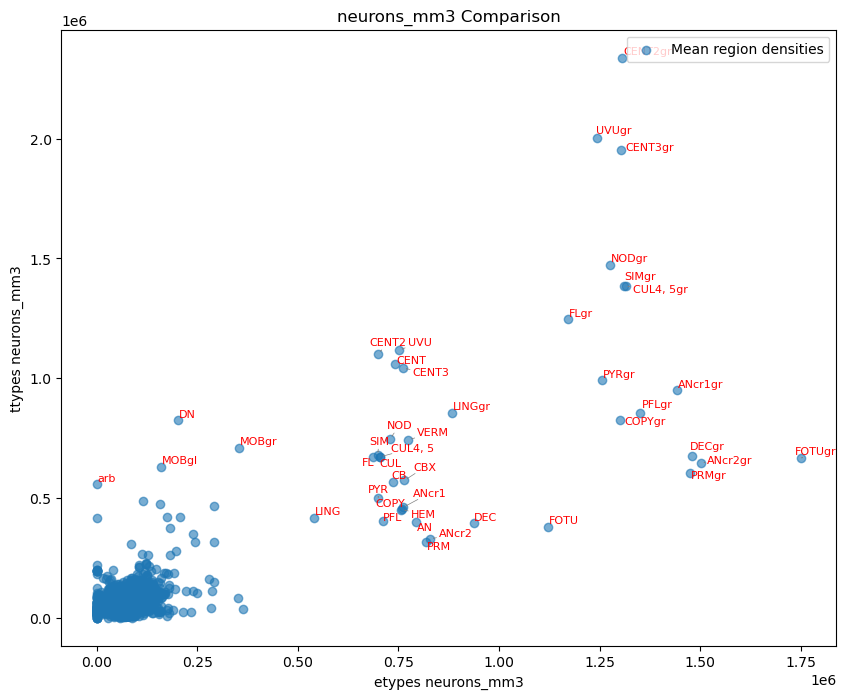

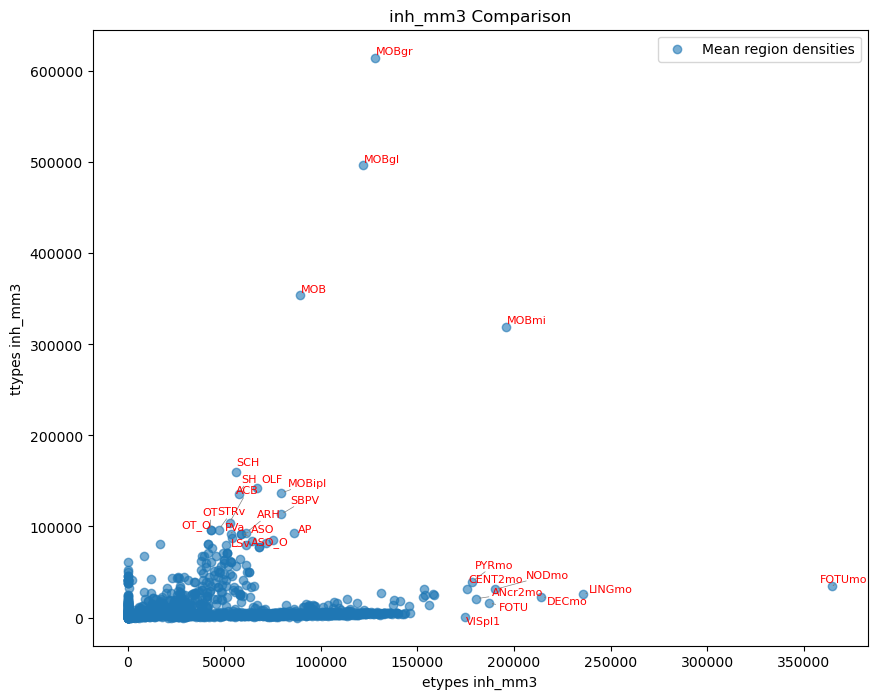

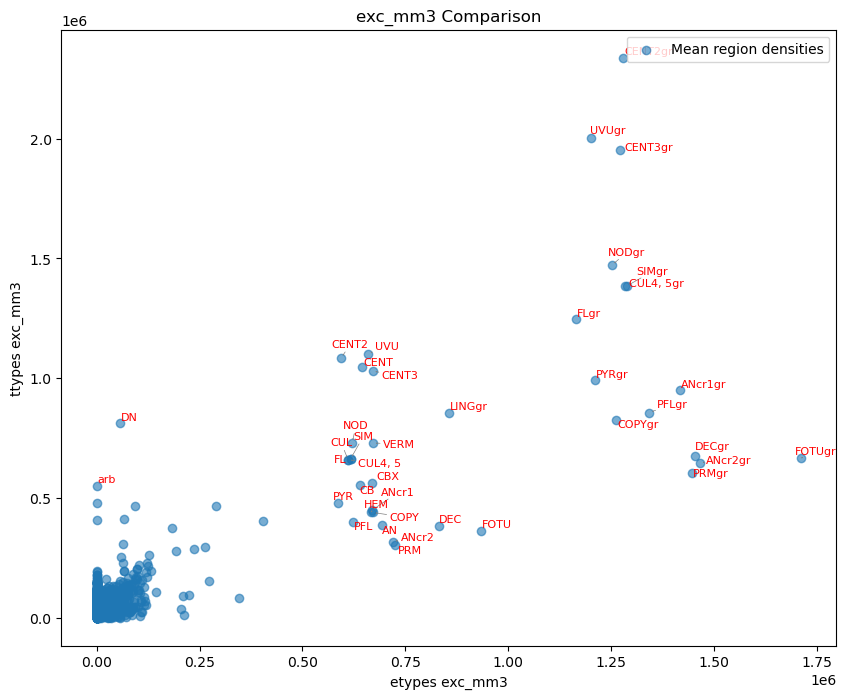

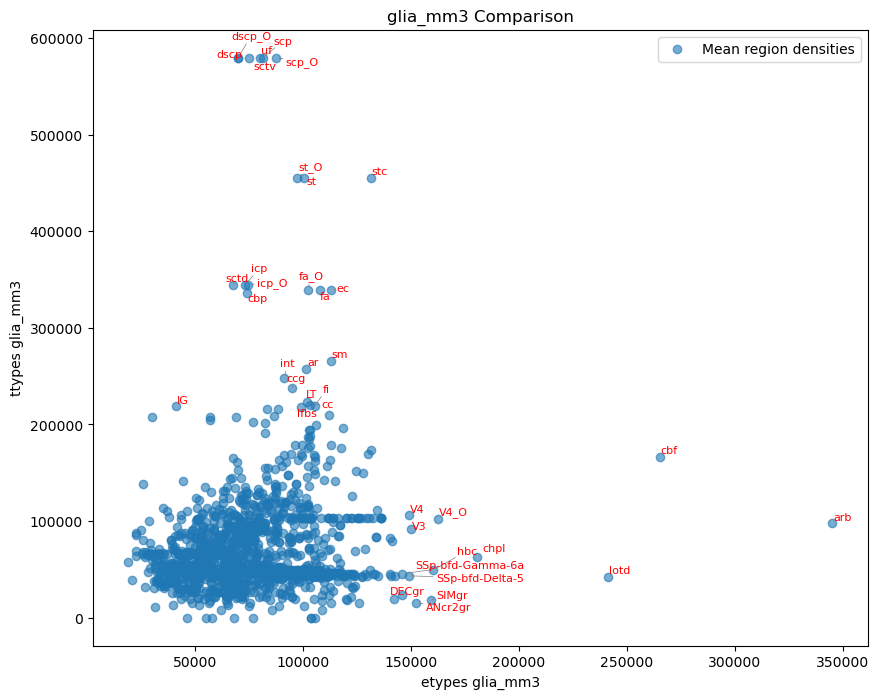

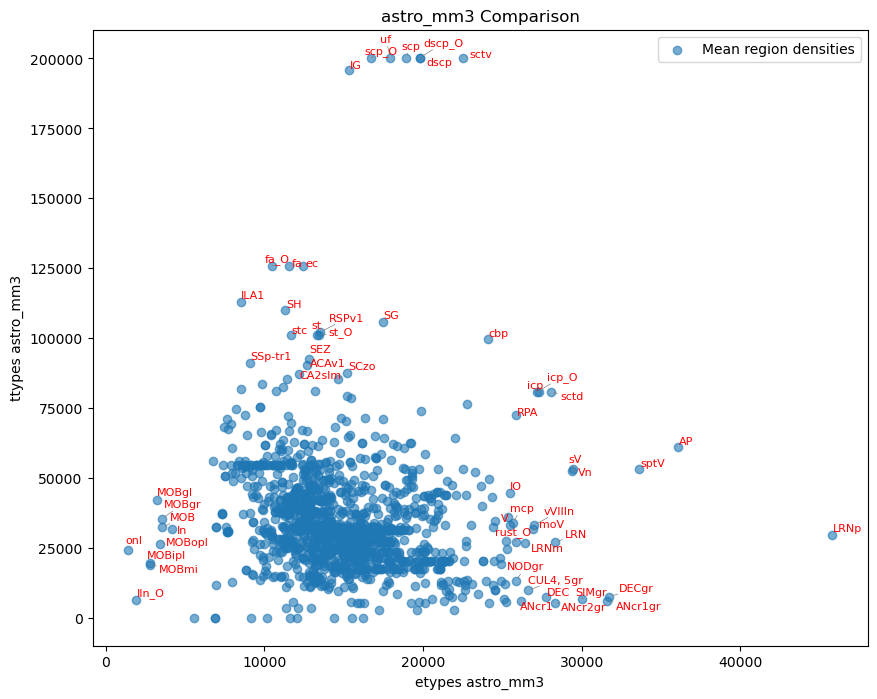

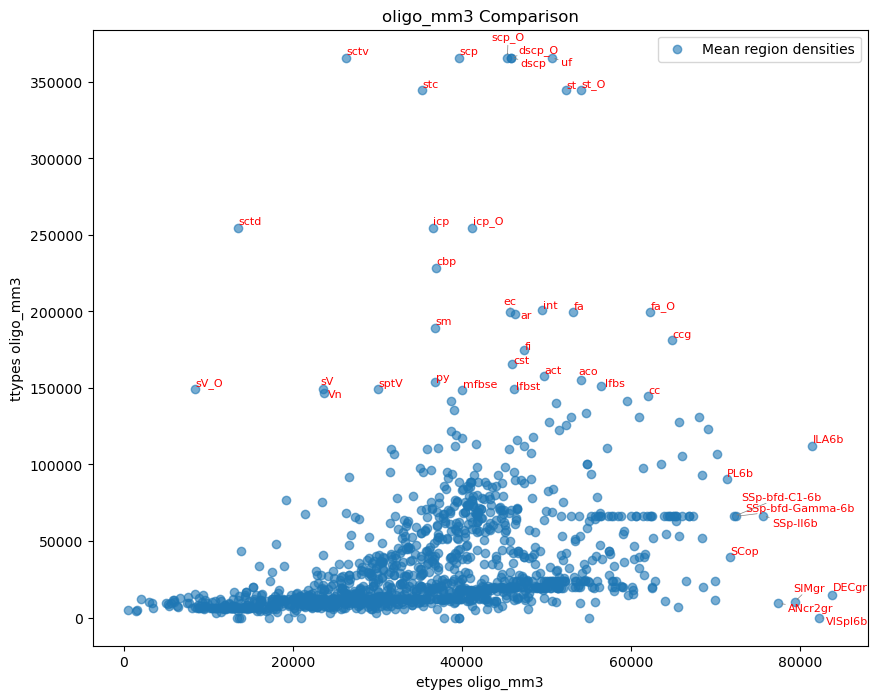

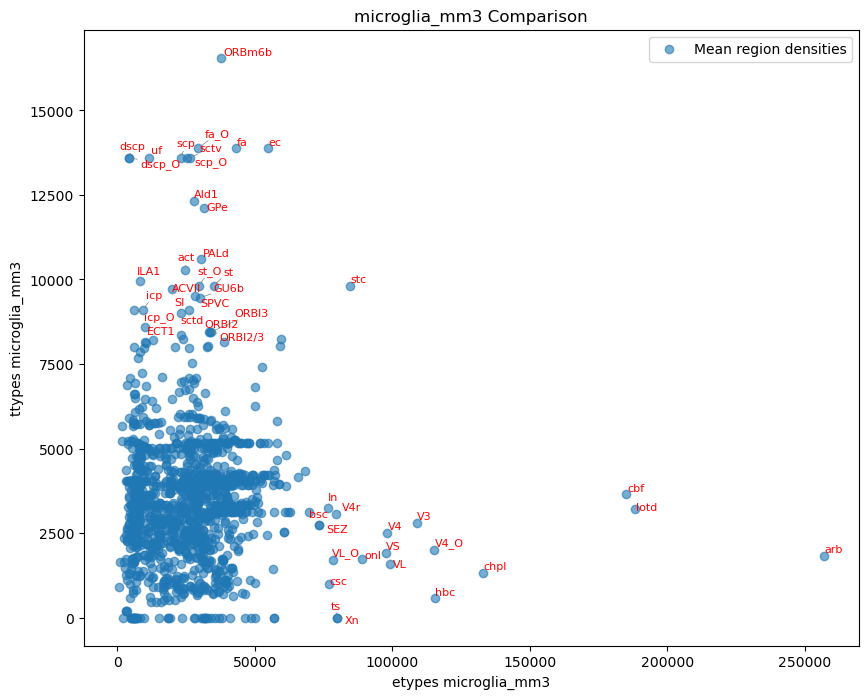

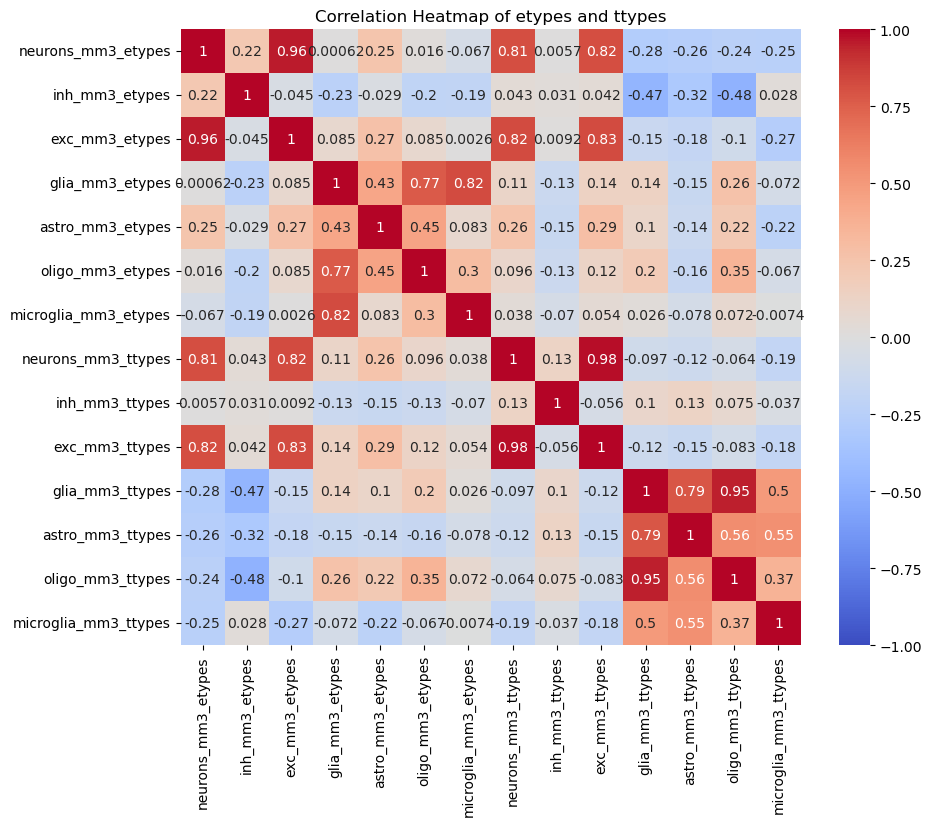

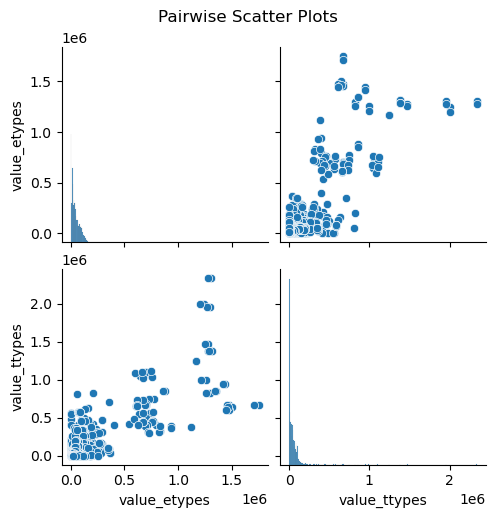

In [82]:
# Calculate Z-scores for detecting outliers
etypes_zscores = etypes[columns_to_check].apply(zscore)
ttypes_zscores = ttypes[columns_to_check].apply(zscore)

# Define a threshold for Z-score to identify outliers
z_threshold = 2.5

# Create a directory to save the plots (optional)
import os
output_dir = 'scatter_plots'
os.makedirs(output_dir, exist_ok=True)

# Plot each scatter plot in a separate figure and save as PNG
for column in columns_to_check:
    plt.figure(figsize=(10, 8))
    plt.scatter(etypes[column], ttypes[column], alpha=0.6, label='Mean region densities')

    # Identify outliers in both datasets
    etypes_outliers = etypes_zscores[column].abs() > z_threshold
    ttypes_outliers = ttypes_zscores[column].abs() > z_threshold

    # Combine outliers from both etypes and ttypes
    combined_outliers = etypes_outliers | ttypes_outliers

    # Collect annotations for adjustment
    annotations = []
    for idx, outlier in etypes[combined_outliers].iterrows():
        annotation = plt.annotate(outlier['acronym'],
                                  (outlier[column], ttypes.loc[idx, column]),
                                  fontsize=8, color='red')
        annotations.append(annotation)

    # Adjust text to avoid overlap
    adjust_text(annotations, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    plt.xlabel(f'etypes {column}')
    plt.ylabel(f'ttypes {column}')
    plt.title(f'{column} Comparison')
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig(f"{output_dir}/{column}_comparison.png", format='png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

# Combine data for correlation heatmap
combined_data = etypes.set_index('acronym').join(ttypes.set_index('acronym'), lsuffix='_etypes', rsuffix='_ttypes')

# Compute correlations
correlation = combined_data.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of etypes and ttypes')

# Save the heatmap as a PNG file
plt.savefig(f"{output_dir}/correlation_heatmap.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

# Pairwise Scatter Plot (pairplot)
combined_long = pd.concat([etypes.melt(id_vars='acronym', var_name='type', value_name='value_etypes'),
                           ttypes.melt(id_vars='acronym', var_name='type', value_name='value_ttypes')],
                          axis=1)

g = sns.pairplot(combined_long[['value_etypes', 'value_ttypes']])
g.fig.suptitle('Pairwise Scatter Plots', y=1.02)

# Save the pairwise scatter plot as a PNG file
g.savefig(f"{output_dir}/pairwise_scatter_plots.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

In [83]:
%%time

regions = [
    "Thalamus", "Cerebellum", "Main olfactory bulb", "Isocortex", "Hippocampal formation", "Hypothalamus", "fiber tracts", "ventricular systems", "Brain stem", "Cerebellar cortex", "Cerebellar nuclei", "Cerebral nuclei", "Cerebral cortex", "Cortical subplate", "Olfactory areas"
]

path ='/gpfs/bbp.cscs.ch/data/project/proj84/atlas_pipeline_runs/2024-05-15T22:44:26+02:00/hierarchy_ccfv3_l23split_barrelsplit.json'
region_map = RegionMap.load_json(path)

# df_region_map = pd.DataFrame()
# df_region_map = region_map.as_dataframe()
# df_region_map_reset = df_region_map.reset_index()
# # Step 2: Select only the 'index', 'acronym', and 'name' columns
# df_region_map_filtered = df_region_map_reset[['id', 'acronym', 'name']]

# save_file_here = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/df_hierarchy_ccfv3_l23split_barrelsplit.csv'
# df = pd.read_csv(save_file_here, index_col=0)

def read_json(path):
   with open(path, 'r') as myfile:
      data = myfile.read()
   return json.loads(data)

def find_subtree(node, key, value, children_key):
   if key in node and node[key] == value:
      return node
      
   to_visit = node[children_key]
   while len(to_visit) != 0:
      child = to_visit[0]
      to_visit = to_visit[1:]
      if key in child and child[key] == value:
         return child
      to_visit.extend(child[children_key])
   return None
   
def is_leaf(node, children_key):
   return len(node[children_key]) == 0
   
def get_leaves(node, children_key):
   to_visit = [node]
   leaves = []
   while len(to_visit) != 0:
      child = to_visit[0]
      to_visit = to_visit[1:]
      if is_leaf(child, children_key):
         leaves.append(child)
      to_visit.extend(child[children_key])
   return leaves

data = read_json(path)

# Define a threshold for Z-score to identify outliers
z_threshold = 2.5

# Create a directory to save the plots
import os
output_dir = 'scatter_plots/regions'
os.makedirs(output_dir, exist_ok=True)

CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 43.9 ms


In [84]:
%%time

# Use a non-interactive backend to block plotting
import matplotlib
matplotlib.use('Agg')

for reg in regions:
    etypes = f_etypes.dropna(subset=columns_to_check, how='all')
    ttypes = f_ttypes.dropna(subset=columns_to_check, how='all')
    
    # Keep only the columns that are in columns_to_check, plus 'acronym' if you need it
    etypes = etypes.loc[:, ['acronym'] + columns_to_check]  # Including 'acronym' for indexing or merging purposes
    ttypes = ttypes.loc[:, ['acronym'] + columns_to_check]  # Including 'acronym' for indexing or merging purposes
    subtree = find_subtree(data["msg"][0], "name", reg, "children")
    leaves = get_leaves(subtree, "children")
    reg_acr_list = [leaf['acronym'] for leaf in leaves]
    etypes = etypes[etypes['acronym'].isin(reg_acr_list)]
    ttypes = ttypes[ttypes['acronym'].isin(reg_acr_list)]
    # Calculate Z-scores for detecting outliers
    etypes_zscores = etypes[columns_to_check].apply(zscore)
    ttypes_zscores = ttypes[columns_to_check].apply(zscore)

    
    # Plot each scatter plot in a separate figure and save as PNG
    for column in columns_to_check:
        plt.figure(figsize=(10, 8))
        plt.scatter(etypes[column], ttypes[column], alpha=0.6, label='Mean region densities')
    
        # Identify outliers in both datasets
        etypes_outliers = etypes_zscores[column].abs() > z_threshold
        ttypes_outliers = ttypes_zscores[column].abs() > z_threshold
    
        # Combine outliers from both etypes and ttypes
        combined_outliers = etypes_outliers | ttypes_outliers
    
        # Collect annotations for adjustment
        annotations = []
        for idx, outlier in etypes[combined_outliers].iterrows():
            annotation = plt.annotate(outlier['acronym'],
                                      (outlier[column], ttypes.loc[idx, column]),
                                      fontsize=8, color='red')
            annotations.append(annotation)
    
        # Adjust text to avoid overlap
        adjust_text(annotations, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    
        plt.xlabel(f'etypes {column}')
        plt.ylabel(f'ttypes {column}')
        plt.title(f'{reg} {column} Comparison')
        plt.legend()
    
        # Save the plot as a PNG file
        plt.savefig(f"{output_dir}/{reg}_{column}_comparison.png", format='png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # Combine data for correlation heatmap
    combined_data = etypes.set_index('acronym').join(ttypes.set_index('acronym'), lsuffix='_etypes', rsuffix='_ttypes')
    
    # Compute correlations
    correlation = combined_data.corr()
    
    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of etypes and ttypes')
    
    # Save the heatmap as a PNG file
    plt.savefig(f"{output_dir}/{reg}_correlation_heatmap.png", format='png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Pairwise Scatter Plot (pairplot)
    combined_long = pd.concat([etypes.melt(id_vars='acronym', var_name='type', value_name='value_etypes'),
                               ttypes.melt(id_vars='acronym', var_name='type', value_name='value_ttypes')],
                              axis=1)
    
    g = sns.pairplot(combined_long[['value_etypes', 'value_ttypes']])
    g.fig.suptitle('Pairwise Scatter Plots', y=1.02)
    
    # Save the pairwise scatter plot as a PNG file
    g.savefig(f"{output_dir}/{reg}_pairwise_scatter_plots.png", format='png', dpi=300, bbox_inches='tight')
    plt.close(g.fig)

CPU times: user 1min 26s, sys: 1.39 s, total: 1min 27s
Wall time: 1min 28s


In [57]:
reg = "Cerebellar cortex"
etypes = f_etypes.dropna(subset=columns_to_check, how='all')
ttypes = f_ttypes.dropna(subset=columns_to_check, how='all')

# Keep only the columns that are in columns_to_check, plus 'acronym' if you need it
etypes = etypes.loc[:, ['acronym'] + columns_to_check]  # Including 'acronym' for indexing or merging purposes
ttypes = ttypes.loc[:, ['acronym'] + columns_to_check]  # Including 'acronym' for indexing or merging purposes
subtree = find_subtree(data["msg"][0], "name", reg, "children")
leaves = get_leaves(subtree, "children")
reg_acr_list = [leaf['acronym'] for leaf in leaves]
etypes = etypes[etypes['acronym'].isin(reg_acr_list)]
ttypes = ttypes[ttypes['acronym'].isin(reg_acr_list)]

In [58]:
ttypes

,acronym,neurons_mm3,inh_mm3,exc_mm3,glia_mm3,astro_mm3,oligo_mm3,microglia_mm3
1474,LINGmo,49122.0,49122.0,0.0,15996.0,8918.0,6936.0,141.0
1476,LINGgr,713970.0,424.0,713545.0,15996.0,8918.0,6936.0,141.0
1479,CENT2mo,60179.0,60179.0,0.0,16391.0,8775.0,6944.0,671.0
1481,CENT2gr,1950392.0,854.0,1949537.0,16391.0,8775.0,6944.0,671.0
1483,CENT3mo,49199.0,47683.0,1515.0,19875.0,9933.0,9186.0,755.0
1485,CENT3gr,1629312.0,891.0,1628420.0,19875.0,9933.0,9186.0,755.0
1496,"CUL4, 5mo",43245.0,43209.0,36.0,15996.0,7356.0,7933.0,706.0
1498,"CUL4, 5gr",1155829.0,832.0,1154997.0,15996.0,7356.0,7933.0,706.0
1500,DECmo,43698.0,43698.0,0.0,17177.0,5588.0,10944.0,643.0
1502,DECgr,561939.0,608.0,561331.0,17177.0,5588.0,10944.0,643.0


In [45]:
#Only Dan's specific regions. 
# Using iterrows()
for index, row in merged_df[merged_df['acronym'].isin(acronyms)].iterrows():
    print(row['acronym'], row['id'], row['name'], )
    id_ = row['id']
    mask = (CCFv3a == id_)
    filtered_inh = inh[mask].mean()
    filtered_exc = exc[mask].mean()
    filtered_glia = glia[mask].mean()
    filtered_neuron = neuron[mask].mean()
    print(f"mean INH: {filtered_inh}, mean EXC: {filtered_exc}, mean GLIA: {filtered_glia}, mean neuron {filtered_neuron}")
    

CA1slm 391 Field CA1, stratum lacunosum-moleculare
mean INH: 2565.0, mean EXC: 2411.0, mean GLIA: 67657.0, mean neuron 4977.0
CA1so 399 Field CA1, stratum oriens
mean INH: 5047.0, mean EXC: 28703.0, mean GLIA: 49623.0, mean neuron 33750.0
CA1sp 407 Field CA1, pyramidal layer
mean INH: 3229.0, mean EXC: 35776.0, mean GLIA: 31101.0, mean neuron 39006.0
CA1sr 415 Field CA1, stratum radiatum
mean INH: 2671.0, mean EXC: 17351.0, mean GLIA: 39386.0, mean neuron 20022.0
CA2slm 431 Field CA2, stratum lacunosum-moleculare
mean INH: 3659.0, mean EXC: 11430.0, mean GLIA: 77201.0, mean neuron 15090.0
CA2so 438 Field CA2, stratum oriens
mean INH: 4308.0, mean EXC: 35453.0, mean GLIA: 46708.0, mean neuron 39761.0
CA2sp 446 Field CA2, pyramidal layer
mean INH: 3438.0, mean EXC: 49093.0, mean GLIA: 28101.0, mean neuron 52532.0
CA2sr 454 Field CA2, stratum radiatum
mean INH: 4332.0, mean EXC: 9566.0, mean GLIA: 56523.0, mean neuron 13898.0
CA3slm 471 Field CA3, stratum lacunosum-moleculare
mean INH: 32

```Python
CA1 sp expected inhibitory: 13520 dorsal 10130 ventral
CA1 sp expected neurons: 447500 dorsal 180500 ventral
Region selected: Field CA1, stratum oriens
CA1 so expected inhibitory: 6480 dorsal 10500 ventral
Region selected: Field CA1, stratum radiatum
CA1 sr expected inhibitory: 6480 dorsal 10500 ventral
Region selected: Field CA1, stratum lacunosum-moleculare
CA1 slm expected inhibitory: 8420 dorsal 8820 ventral
Region selected: Field CA2, pyramidal layer
CA2 sp expected inhibitory: 13520 dorsal 10130 ventral
CA2 sp expected neurons: 447500 dorsal 180500 ventral
Region selected: Field CA2, stratum oriens
CA2 so expected inhibitory: 6480 dorsal 10500 ventral
Region selected: Field CA2, stratum radiatum
CA2 sr expected inhibitory: 3240 dorsal 4260 ventral
Region selected: Field CA2, stratum lacunosum-moleculare
CA2 slm expected inhibitory: 8420 dorsal 8820 ventral
Region selected: Field CA3, pyramidal layer
CA2 sp expected inhibitory: 7560 dorsal 10540 ventral
CA2 sp expected neurons: 172400
Region selected: Field CA3, stratum oriens
CA3 so expected inhibitory: 3170 dorsal 5460 ventral
Region selected: Field CA3, stratum radiatum
CA2 sr expected inhibitory: 7890 dorsal 6590 ventral
Region selected: Field CA3, stratum lacunosum-moleculare
CA3 slm expected inhibitory: 5780 dorsal 7200 ventral
Region selected: Posterior complex of the thalamus
VPL expected 55340.64 excitatory /2126.28 inhibitory/ 57466.92 neurons /mm3
Region selected: Ventral posteromedial nucleus of the thalamus
VPM expected 67940.58 excitatory/2978.61 inhibitory/ 70919.19 neurons /mm3
Region selected: Field CA1, pyramidal layer
PO expected --/161.08663 inhibitory/-- cells/mm3
Region selected: Ventral posterolateral nucleus of the thalamus
```

In [46]:
# Using iterrows()
for index, row in merged_df[merged_df['name'].isin(names)].iterrows():
    print(row['name'], row['acronym'], row['id'], )
    id_ = row['id']
    mask = (CCFv3a == id_)
    filtered_inh = inh[mask].mean()
    filtered_exc = exc[mask].mean()
    filtered_glia = glia[mask].mean()
    filtered_neuron = neuron[mask].mean()
    print(f"mean INH: {filtered_inh}, mean EXC: {filtered_exc}, mean GLIA: {filtered_glia}, mean neuron {filtered_neuron}")
    

Main olfactory bulb, glomerular layer MOBgl 212
mean INH: 42588.0, mean EXC: 11418.0, mean GLIA: 42816.0, mean neuron 54007.0
Main olfactory bulb, granule layer MOBgr 220
mean INH: 67405.0, mean EXC: 10444.0, mean GLIA: 40916.0, mean neuron 77849.0
Main olfactory bulb, inner plexiform layer MOBipl 228
mean INH: 69652.0, mean EXC: 6786.0, mean GLIA: 23088.0, mean neuron 76438.0
Main olfactory bulb, mitral layer MOBmi 236
mean INH: 68420.0, mean EXC: 6534.0, mean GLIA: 23822.0, mean neuron 74954.0
Main olfactory bulb, outer plexiform layer MOBopl 244
mean INH: 50002.0, mean EXC: 9186.0, mean GLIA: 29557.0, mean neuron 59188.0
Striatum STR 477
mean INH: 53305.0, mean EXC: 6124.0, mean GLIA: 62200.0, mean neuron 59430.0


```Python
Region selected: Main olfactory bulb, glomerular layer
Main olfactory bulb, glomerular layer expected neurons: 630000 cells/mm3
Region selected: Main olfactory bulb, granule layer
Main olfactory bulb, granule layer expected neurons: 710000
Region selected: Main olfactory bulb, inner plexiform layer
Main olfactory bulb, inner plexiform layer expected neurons: 150000
Region selected: Main olfactory bulb, mitral layer
Main olfactory bulb, mitral layer expected neurons: 350000
Region selected: Main olfactory bulb, outer plexiform layer
Main olfactory bulb, outer plexiform layer expected neurons: 80000
Region selected: Striatum
Striatum expected neurons: 78560 cells/mm3
```